In [1]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# 1. Load Data
try:
    data = pd.read_csv("../data/processed/ethiopia_fi_modeled.csv")
    data['observation_date'] = pd.to_datetime(data['observation_date'])
    print("✅ Data Loaded Successfully")
except FileNotFoundError:
    print("❌ Error: Check file path (try 'data/processed/...' vs '../data/processed/...')")

# 2. Filter for Access Target
target = data[
    (data['indicator_code'] == 'ACC_OWNERSHIP') &
    (data['record_type'] == 'observation')
].copy()

target['year'] = target['observation_date'].dt.year
target.rename(columns={'value_numeric': 'access_rate'}, inplace=True)

# 3. Setup Forecast Horizon
forecast_years = [2025, 2027, 2030]
all_years = list(target['year']) + forecast_years

print("Historical Data:")
print(target[['year', 'access_rate']])

✅ Data Loaded Successfully
Historical Data:
    year  access_rate
0   2014         22.0
1   2017         35.0
5   2021         46.0
6   2021         56.0
7   2021         36.0
25  2024         49.0


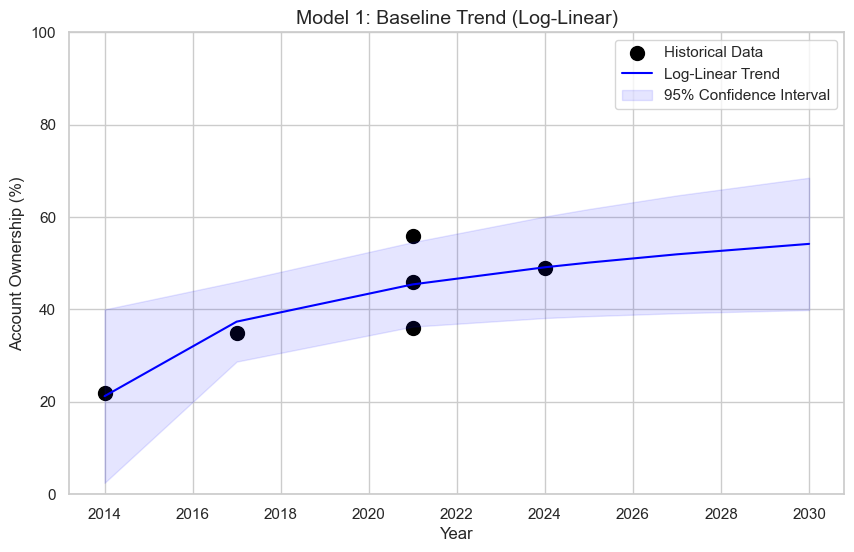

R-Squared: 0.718
2030 Baseline Forecast: 54.2%


In [2]:
# %%
# ==========================================
# MODEL 1: Trend Regression (Log-Linear)
# ==========================================

# Prepare Data (Log Transformation for S-curve shape)
y = target['access_rate']
base_year = target['year'].min() - 1
target['log_years'] = np.log(target['year'] - base_year)

# Fit OLS
X_log = sm.add_constant(target['log_years'])
model_log = sm.OLS(y, X_log).fit()

# Predict
all_years_since_base = [yr - base_year for yr in all_years]
all_log_years = np.log(all_years_since_base)
X_all_log = sm.add_constant(all_log_years)

# Get Prediction + CI
pred_obj = model_log.get_prediction(X_all_log)
pred_summary = pred_obj.summary_frame(alpha=0.05)
pred_summary['year'] = all_years

# --- PLOT 1: TREND REGRESSION ---
plt.figure(figsize=(10, 6))
plt.scatter(target['year'], y, color='black', s=100, label='Historical Data')
plt.plot(all_years, pred_summary['mean'], color='blue', label='Log-Linear Trend')
plt.fill_between(all_years, pred_summary['mean_ci_lower'], pred_summary['mean_ci_upper'],
                 color='blue', alpha=0.1, label='95% Confidence Interval')

plt.title('Model 1: Baseline Trend (Log-Linear)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Account Ownership (%)')
plt.legend()
plt.ylim(0, 100)
plt.show()

print(f"R-Squared: {model_log.rsquared:.3f}")
print(f"2030 Baseline Forecast: {pred_summary['mean'].iloc[-1]:.1f}%")

Telebirr-Implied Access Rate (2025): 54.0%


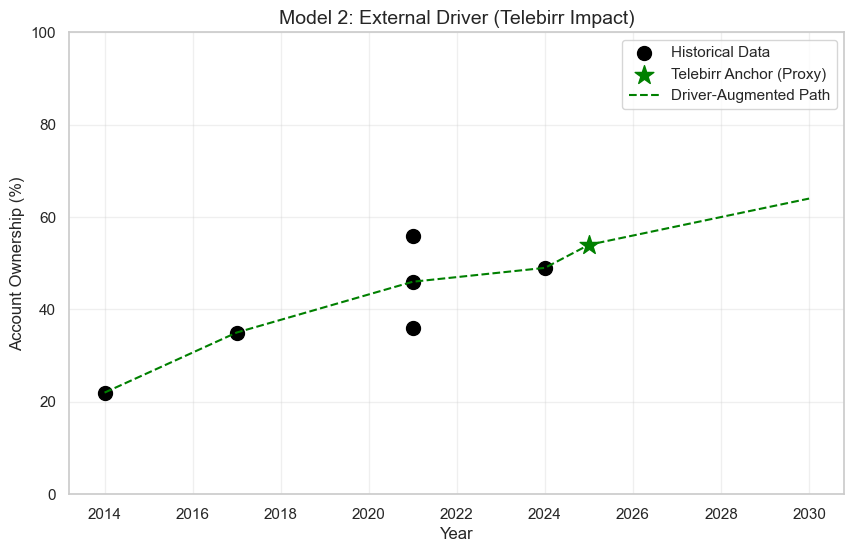

In [3]:
# %%
# ==========================================
# MODEL 2: External Driver (Telebirr Proxy)
# ==========================================

# 1. Calculate the Anchor
# Logic: 54M users / 60M adults * 0.60 active rate
telebirr_users = 54.0
adult_pop = 60.0
conversion_factor = 0.60

implied_rate = (telebirr_users / adult_pop * 100) * conversion_factor
print(f"Telebirr-Implied Access Rate (2025): {implied_rate:.1f}%")

# 2. Define the Optimistic Path (Jumping to the Anchor)
last_val = y.iloc[-1]
# Create a path that connects last historical point -> Telebirr Anchor -> Future Growth
driver_forecast = []
for yr in all_years:
    if yr <= target['year'].max():
        # History
        val = target[target['year'] == yr]['access_rate'].values[0]
    else:
        # Future: Start at Anchor and grow by 2% per year (Network Effects)
        years_into_future = yr - 2025
        val = implied_rate + (years_into_future * 2.0)
    driver_forecast.append(val)

# --- PLOT 2: DRIVER MODEL ---
plt.figure(figsize=(10, 6))
plt.scatter(target['year'], y, color='black', s=100, label='Historical Data')

# Plot the Anchor Point
plt.scatter([2025], [implied_rate], color='green', s=200, marker='*', zorder=5, label='Telebirr Anchor (Proxy)')

# Plot the Resulting Path
plt.plot(all_years, driver_forecast, color='green', linestyle='--', label='Driver-Augmented Path')

plt.title('Model 2: External Driver (Telebirr Impact)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Account Ownership (%)')
plt.legend()
plt.ylim(0, 100)
plt.grid(True, alpha=0.3)
plt.show()


=== Model 2: External Driver (Telebirr + M-Pesa) ===
Total Digital Wallets: 64.0 M
Estimated Unique Users: 62.0 M
Dual-Engine Anchor Rate (2025): 62.0%


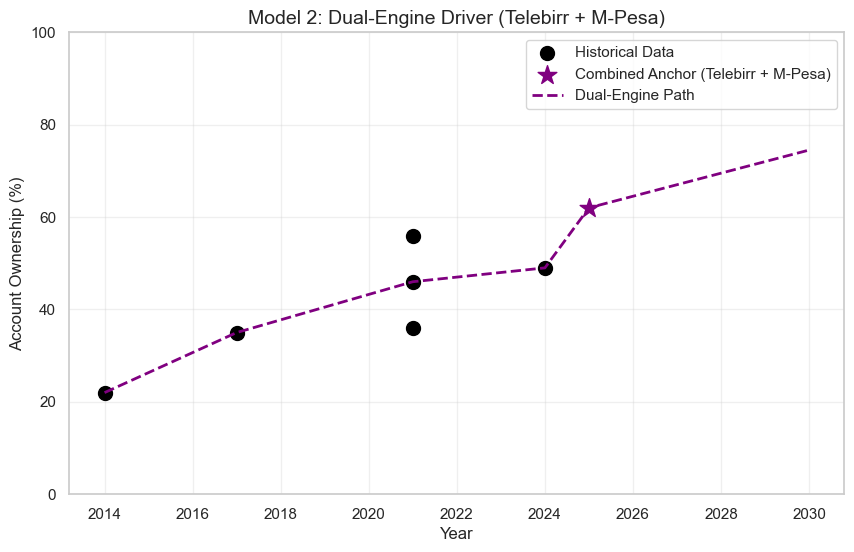

In [6]:
# %%
# ==========================================
# MODEL 2: External Driver (Dual-Engine Proxy)
# ==========================================
# Logic: Telebirr (54M) + M-Pesa (10M) drive the new reality.
# We must account for "Multi-Homing" (people having both).

print("\n=== Model 2: External Driver (Telebirr + M-Pesa) ===")

# 1. Get User Counts (Millions)
telebirr_users = 54.0
mpesa_users = 10.0   # From Task 1 Enrichment
adult_pop = 60.0

# 2. Calculate "Unique" Digital Users
# Assumption: 20% of M-Pesa users also have Telebirr (Overlap)
overlap_factor = 0.20
unique_mpesa = mpesa_users * (1 - overlap_factor)

total_digital_users = telebirr_users + unique_mpesa
print(f"Total Digital Wallets: {telebirr_users + mpesa_users} M")
print(f"Estimated Unique Users: {total_digital_users:.1f} M")

# 3. Calculate the Anchor (Active Rate Adjustment)
# We stick to the 60% active conversion rate (Conservative)
conversion_factor = 0.60

implied_rate = (total_digital_users / adult_pop * 100) * conversion_factor
print(f"Dual-Engine Anchor Rate (2025): {implied_rate:.1f}%")

# 4. Define the Driver Path
last_hist_val = y.iloc[-1]
driver_forecast = []

for yr in all_years:
    if yr <= target['year'].max():
        val = target[target['year'] == yr]['access_rate'].values[0]
    else:
        # Future: Start at the Dual Anchor and grow
        years_into_future = yr - 2025
        # Growth is slightly faster (2.5%) due to competition
        val = implied_rate + (years_into_future * 2.5)
    driver_forecast.append(val)

# --- PLOT 2: DUAL DRIVER MODEL ---
plt.figure(figsize=(10, 6))

# Historical
plt.scatter(target['year'], y, color='black', s=100, label='Historical Data')

# Anchors
plt.scatter([2025], [implied_rate], color='purple', s=200, marker='*', zorder=5, label='Combined Anchor (Telebirr + M-Pesa)')

# Path
plt.plot(all_years, driver_forecast, color='purple', linestyle='--', linewidth=2, label='Dual-Engine Path')

plt.title('Model 2: Dual-Engine Driver (Telebirr + M-Pesa)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Account Ownership (%)')
plt.legend()
plt.ylim(0, 100)
plt.grid(True, alpha=0.3)
plt.show()

# Update the Optimistic Scenario for the final merge

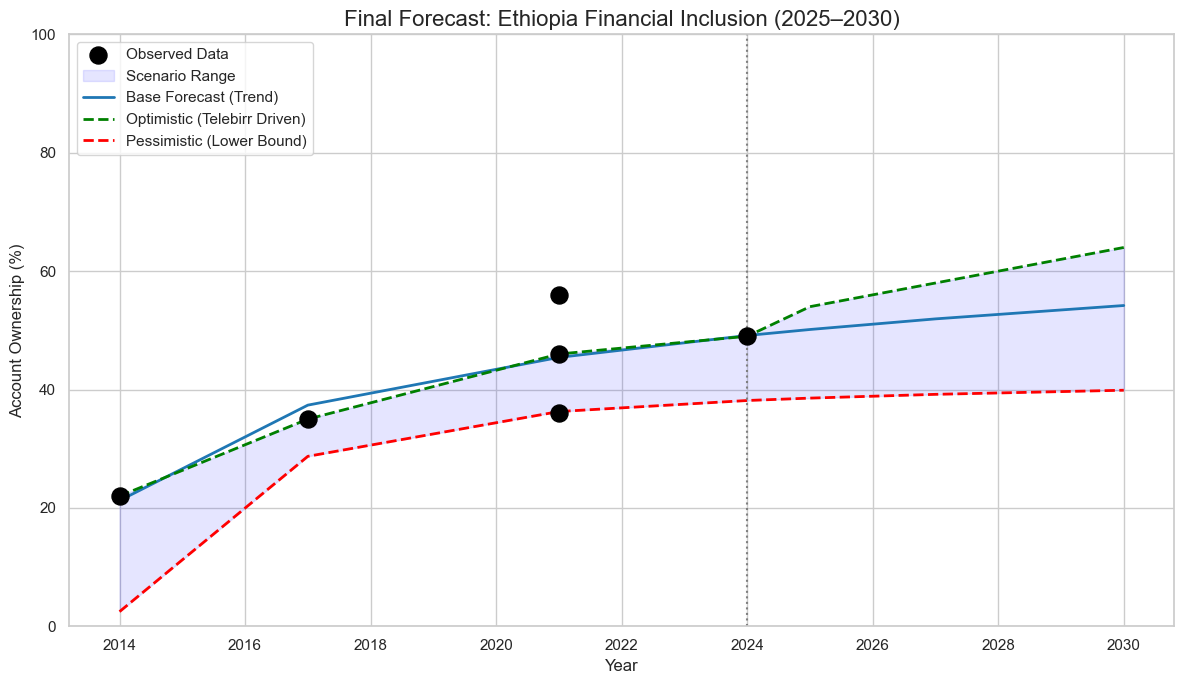


=== FINAL FORECAST ===
   Year  Pessimistic  Base_Case  Optimistic
6  2025         38.5       50.1        54.0
7  2027         39.2       51.9        58.0
8  2030         39.9       54.2        64.0


In [4]:
# %%
# ==========================================
# MODEL 3: Scenario Synthesis (Final Ensemble)
# ==========================================

# 1. Define Scenarios
# Pessimistic: Lower bound of Trend (History repeats, no boom)
scen_pessimistic = pred_summary['mean_ci_lower'].values

# Base Case: Mean of Trend (Conservative)
scen_base = pred_summary['mean'].values

# Optimistic: The Driver Model (Tech Boom) cap at 100%
scen_optimistic = np.minimum(driver_forecast, 100)


# --- PLOT 3: FINAL SYNTHESIS ---
fig, ax = plt.subplots(figsize=(12, 7))

# Historical
ax.scatter(target['year'], y, s=150, color='black', label='Observed Data', zorder=5)

# Scenario Range (Shaded)
ax.fill_between(all_years, scen_pessimistic, scen_optimistic,
                color='blue', alpha=0.1, label='Scenario Range')

# Lines
ax.plot(all_years, scen_base, color='#1f77b4', linewidth=2, label='Base Forecast (Trend)')
ax.plot(all_years, scen_optimistic, color='green', linestyle='--', linewidth=2, label='Optimistic (Telebirr Driven)')
ax.plot(all_years, scen_pessimistic, color='red', linestyle='--', linewidth=2, label='Pessimistic (Lower Bound)')

# Formatting
ax.axvline(x=target['year'].max(), linestyle=':', color='gray')
ax.set_title("Final Forecast: Ethiopia Financial Inclusion (2025–2030)", fontsize=16)
ax.set_xlabel("Year")
ax.set_ylabel("Account Ownership (%)")
ax.set_ylim(0, 100)
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Export
forecast_df = pd.DataFrame({
    'Year': all_years,
    'Pessimistic': np.round(scen_pessimistic, 1),
    'Base_Case': np.round(scen_base, 1),
    'Optimistic': np.round(scen_optimistic, 1)
})
print("\n=== FINAL FORECAST ===")
print(forecast_df.tail(3))
forecast_df.to_csv("../data/processed/ethiopia_fi_forecast_final.csv", index=False)


=== EXECUTIVE SUMMARY METRICS (2030) ===
📉 Status Quo (Base):      54.2% Ownership
🚀 Digital Boom (Opt):     64.0% Ownership
💰 THE PRIZE (Dividend):   +9.8 Percentage Points
👥 Human Impact:           ~6.7 MILLION additional adults included


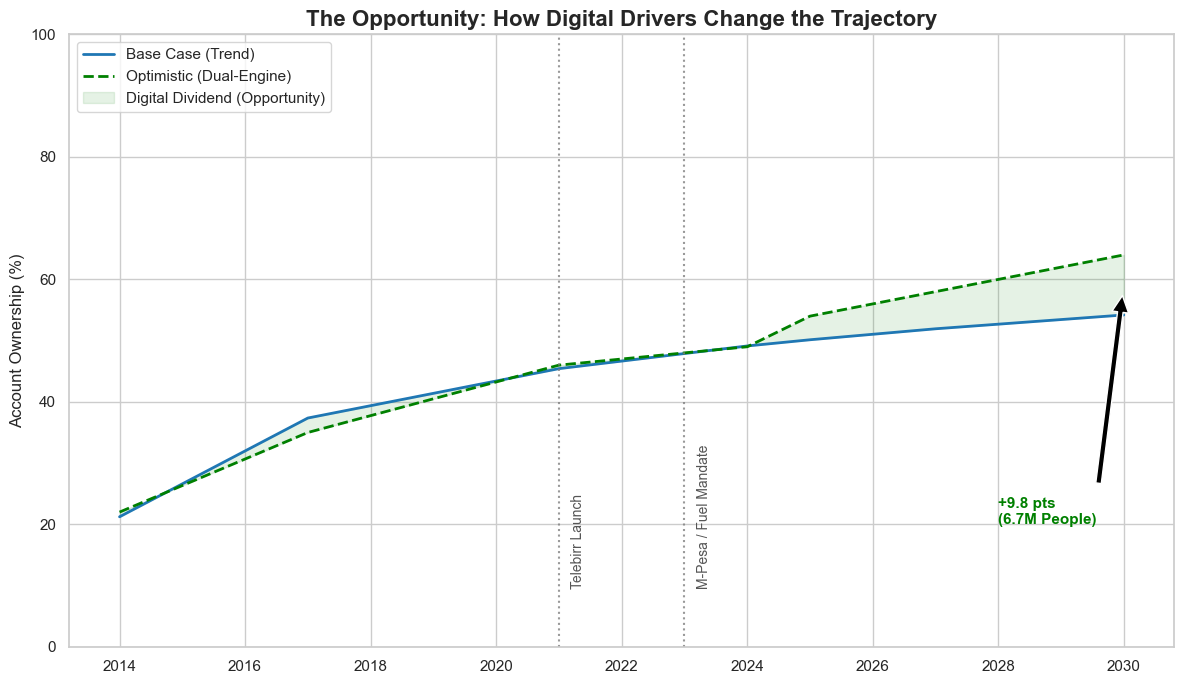

In [7]:
# %%
# ==========================================
# FINAL POLISH: Metrics & Storytelling
# ==========================================

# 1. Calculate the "Digital Dividend" (The Gap)
# How much better is the Optimistic Case vs. Base Case in 2030?
base_2030 = forecast_df.loc[forecast_df['Year'] == 2030, 'Base_Case'].values[0]
opt_2030 = forecast_df.loc[forecast_df['Year'] == 2030, 'Optimistic'].values[0]

gap_pct = opt_2030 - base_2030
# Convert % back to humans (assuming 60M adults grows to ~68M by 2030)
est_pop_2030 = 68.0
people_gained = (gap_pct / 100) * est_pop_2030

print("\n=== EXECUTIVE SUMMARY METRICS (2030) ===")
print(f"📉 Status Quo (Base):      {base_2030:.1f}% Ownership")
print(f"🚀 Digital Boom (Opt):     {opt_2030:.1f}% Ownership")
print(f"💰 THE PRIZE (Dividend):   +{gap_pct:.1f} Percentage Points")
print(f"👥 Human Impact:           ~{people_gained:.1f} MILLION additional adults included")


# 2. Polished "Storytelling" Chart
# Re-plotting with Event Markers to show CAUSALITY
fig, ax = plt.subplots(figsize=(12, 7))

# Scenarios
ax.plot(all_years, scen_base, color='#1f77b4', linewidth=2, label='Base Case (Trend)')
ax.plot(all_years, scen_optimistic, color='green', linestyle='--', linewidth=2, label='Optimistic (Dual-Engine)')

# Highlight the "Dividend" (The Gap)
ax.fill_between(all_years, scen_base, scen_optimistic, color='green', alpha=0.1, label='Digital Dividend (Opportunity)')

# Add Event Markers (The "Why")
events = [
    (2021, "Telebirr Launch"),
    (2023, "M-Pesa / Fuel Mandate")
]

for yr, label in events:
    ax.axvline(x=yr, color='gray', linestyle=':', alpha=0.8)
    ax.text(yr+0.2, 10, label, rotation=90, color='#555', fontsize=10)

# Formatting
ax.set_title("The Opportunity: How Digital Drivers Change the Trajectory", fontsize=16, fontweight='bold')
ax.set_ylabel("Account Ownership (%)")
ax.set_ylim(0, 100)
ax.legend(loc='upper left')

# Annotate the Prize
ax.annotate(f"+{gap_pct:.1f} pts\n({people_gained:.1f}M People)",
            xy=(2030, (base_2030 + opt_2030)/2),
            xytext=(2028, 20),
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=11, fontweight='bold', color='green')

plt.tight_layout()
plt.show()